In [1]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
import scipy.fftpack as sff

**I - Data generation and manipulation**

The objective of this first short part is to create some datasets to get accustomed to them. It will enable us to :
- recall the notion of sparsity ;
- geometrically understand the effect of the mixing.

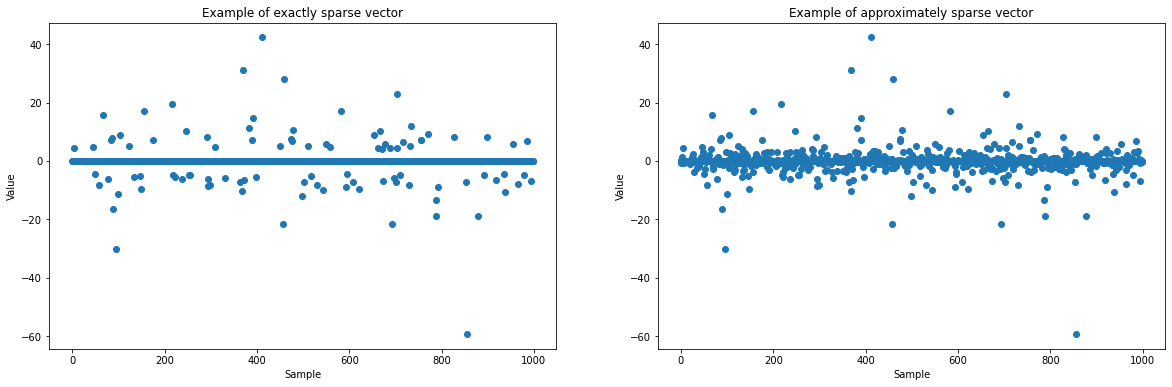

In [2]:
power = 3
approx_sparse = np.random.randn(1000)**power
exact_sparse = approx_sparse*(np.abs(approx_sparse)>4)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.plot(exact_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of exactly sparse vector');

fig.add_subplot(1,2,2)
plt.plot(approx_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of approximately sparse vector');

**1)** What is the difference between an exactly and an approximately sparse signal? Recall the two corresponding definitions.

<blockquote>An exact sparse signal (on the left) has a lot of values equal to zero. A signal $s \in \mathbb{R}$ is said to be -sparse if only $k \ll t$ of its element are non-zeros: $$||s||_0  = k\ll t $$ 
with the pseudo-norm$|| . ||_0$ being the cardinal of the support of s.<br><br>
On the other hand, an approximately sparse signal (on the right) has a lot of values close to zero, but not equal to zero. That is, only a small number k of the signal samples have a large amplitude.</blockquote>


**2)** Now let's start to look at some mixtures and to try to geometrically interpret the impact of the mixing.

<blockquote>As seen in the course, the resulting graph is in the form of a cross, because the probability of a value being equal to zero in both sources simultaneously is really small.</blockquote>

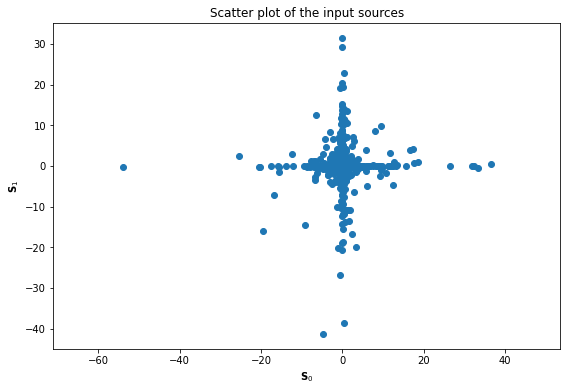

In [3]:
n = 2         # number of sources
t = 1024      # number of samples
noise_level = 80 # noise level, in dB
power = 3 # power exponent used in the source generation



# TO DO : generate a simulated source S matrix. 
# S will be of dimensions n x t.
# Each of the n sources (i.e. lines of S) will follow the approximately sparse 
# law we used above.
# S = np.zeros(n,t) # TO CHANGE
S = np.zeros((n,t))
for i in range(S.shape[0]):
  S[i,:] = np.random.randn(t)**power 

# TO DO : interpret the shape of the scatter plot you obtain
fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

In [4]:
# Here, we generate a mixture matrix (dimensions m x t) from the sources in S  
m = 4         # number of observations

A = np.random.randn(m,n)
X = A@S

noise_level = 120

# To be more realistic, we add some noise to the mixing. 
# Mixtures with SNR > 120 dB can be considered as noiseless for most applications.
if noise_level < 120: 
    #--- Add noise
    N = np.random.randn(m,t)
    N = 10.**(-noise_level/20.)*np.linalg.norm(X)/np.linalg.norm(N)*N
    X = X + N

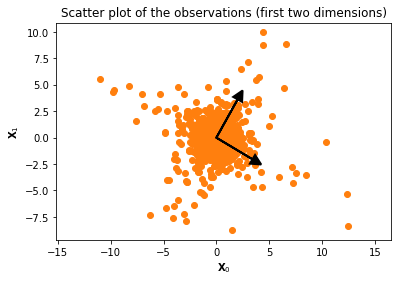

In [99]:
# TO DO : plot the scatter plot of X. What do you see ? 
# What do the directions of the lines you observe correspond ?
# Try several A matrices, noise_values and powers. Note your comments.

plt.title('Scatter plot of the observations (first two dimensions)')
vrange = 0.25*max(np.sqrt(np.sum(X*X, 0)))
plt.arrow( 0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.arrow( 0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(X[0,:], X[1,:], 'C1o', zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');

<blockquote> Multiplying the sources by A* (which give us X) changes the direction of the axes. The directions of the lines in the graph correspond to the 1st and 2nd directions of more variability in our data.

Other comments on parameters:

*  Different A matrix change a lot the results, that is, the final directions of the axes in the observations.
*  Different noise levels visually don’t make a lot of difference in the results.
*  For the power, we should use an odd value, otherwise, with an even one (2,4,6…) the input sources will be all positive, with an L shape (the angle will change when multiply by A*. </blockquote>

**II - Performing non-blind source separation**

**1) Data generation**

Before going into blind source separation, in which we want to find physical **A** and **S** matrices such that **X = AS + N**, let us first consider the simpler setting in which we know **A** and want to recover **S**.
We will consider the noisy mixture of two sine signals.

N.B. : unmixing two sinus signal could be done much more easily than using the algorithms we saw during the class. Nevertheless, focusing on such synthetic data enables an easy visualization. The principle readily extend to more complex datasets, such as images.

(-25.0, 25.0)

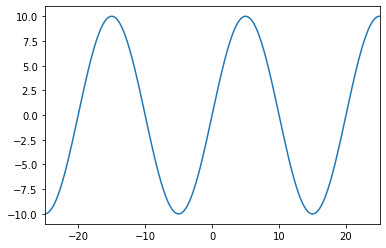

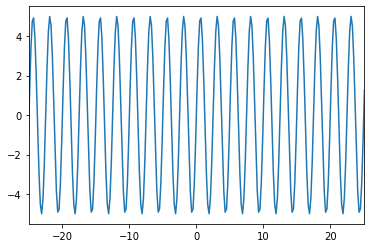

In [5]:
# Source generation
t = 10000
x_abs = np.linspace(-1000,1000,t)

S = np.zeros((2,t))
S[0,:] = 10*np.sin(2*np.pi*0.05*x_abs)
S[1,:] = 5*np.sin(2*np.pi*0.4*x_abs)

plt.figure(),plt.plot(x_abs,S[0,:])
plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs,S[1,:])
plt.xlim([-25,25])

(<Figure size 432x288 with 1 Axes>,
 [<matplotlib.lines.Line2D at 0x7fa3e7b0c990>])

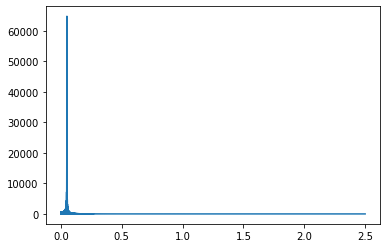

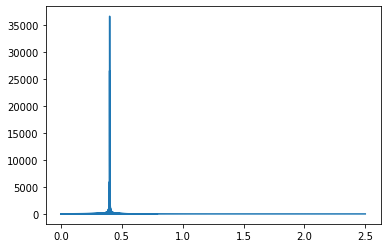

In [6]:
# Transformation into the DCT domain
Sf = sff.dct(S)
# TO DO : what is the objective of using the DCT?
# TO DO : plot the above DCT and justify what you see? Pay attention to the labeling of the x-axis. Try with sinus of various frequencies.
plt.figure(), plt.plot(np.linspace(0,2.5,t),np.absolute(Sf[0]))
plt.figure(), plt.plot(np.linspace(0,2.5,t),np.absolute(Sf[1]))

<blockquote>A discrete cosine transform (DCT) expresses a finite sequence of data points in terms of a sum of cosine functions oscillating at different frequencies.<br><br>We can see above that when we apply the DCT to one sinus signal, each signal with a different frequency will have a different peak in the graph. That said, after we mix them, we will be able to differentiate both peaks and separate them (using the inversibility of the DCT).</blockquote>

(<Figure size 432x288 with 1 Axes>,
 [<matplotlib.lines.Line2D at 0x7fa3e853fd50>])

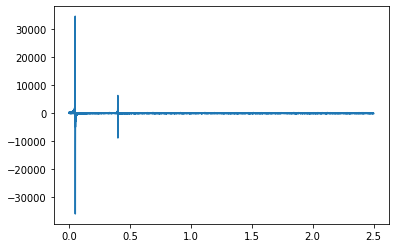

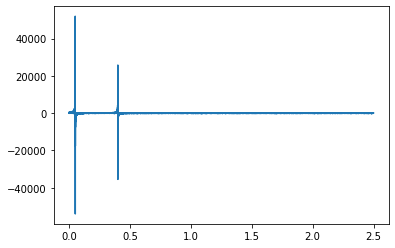

In [16]:
# Data generation : now, we will create a mixture X = AS + N
A = np.array([[0.5547002 , 0.24253563],
       [0.83205029, 0.9701425 ]]) # You can try other A value, but the columns must have a unitary norm.

X = A@S
X = X + 0.5*np.random.randn(np.shape(X)[0],np.shape(X)[1])# You can try other noise values

# TO DO : plot the mixtures. Explain what you see.
# TO DO : compute the DCT of X. Plot it and explain. Which caracteristic of the DCT will we use to recover the sources?

Xf = sff.dct(X)
plt.figure(), plt.plot(np.linspace(0,2.5,t),Xf[0])
plt.figure(), plt.plot(np.linspace(0,2.5,t),Xf[1])

**2) Source separation**

Now that we generated observations from simulated sources, we will focus on the source separation problem: recovering the sources from the observations (and the knowledge of A, since we are here in the non-blind setting).

To do that, we propose here to solve the source separation problem using a sparsity constraint on the sources. The cost function will then be minimized using the ISTA algorithm.

**2-1)** First, write the cost function we want to minimize to perform non-blind sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?


<blockquote>Cost function:
$$argmin_{A \in \mathbb{R}^{m \times n},S \in \mathbb{R}^{n \times t}}\frac{1}{2}||X-AS||^2_F +\lambda||S||_1$$

Where:

*  $\frac{1}{2}||X-AS||^2_F$ is the Data-fidelity.

*  $\lambda||S||_1$ is the Sparsity.


This problem is non-smooth because of the $||.||_1$ term. It's a convex problem because we fixed A.
</blockquote>

**2-2)** Compute the gradient along the S variable of the data-fidelity term.

<blockquote>Gradient along the S variable:

$$\nabla f(S^{(k)}) = A^T(AS-X)$$</blockquote>

**2-3)** Recall what the proximal operator of the l1-norm is.

The proximal operator of the $l_1$ norm is the soft-thresholding operator. That is:

$(prox_{\lambda |.||_1}(v))_i = S_{\lambda}(v) =  \begin{cases} 
      v_i-\lambda &, v_i \ge \lambda \\
      0 &, |v_i\  \le \lambda \\
      v_i+\lambda &, v_i \le -\lambda
\end{cases}$

In [17]:
# TO DO: implement the proximal operator of the l1-norm in the above function:
def prox_l1(S_est,thrd):
  S_est = np.sign(S_est) * np.maximum(np.abs(S_est) - thrd, 0.)
  return S_est


**2-4)** In your report, explain the main idea of the ISTA algorithm. Then, implement it.

<blockquote>The Iterative Shrinkage Thresholding Algorithm (ISTA) is the combination of the gradient descent applied to the S variable of the data-fidelity term and the proximal operator of the $l_1$ norm of the soft-thresholding operator, in a way that we can minimize the cost function for the non-blind sparse source separation.</blockquote>

In [39]:
# TO DO: implement the ISTA algorithm to minimize the cost function you wrote in question II-2-1.
def ISTA(X,A = np.eye(2),n=2,lamb=0,nbIt = 100):
    S_est = np.zeros((A.shape[1],X.shape[1]))
    gamma = 0.9/np.linalg.norm(np.matmul(A.T,A))
    for i in range(nbIt):
      S_est = prox_l1(S_est - gamma*(np.matmul(A.T,(np.matmul(A,S_est)-X))),lamb)       
    return S_est

**2-5)** It's now time to play with the code : launch the ISTA algorithm and look at the results.

In [40]:
S_estf = ISTA(Xf,A = A,n=2,lamb=1000,nbIt = 1000)# TO DO : try various lamb values. What is the minimum value you should no go below? What is the issue with choosing too big values?


(<Figure size 432x288 with 1 Axes>,
 [<matplotlib.lines.Line2D at 0x7fa3e6eb1e50>])

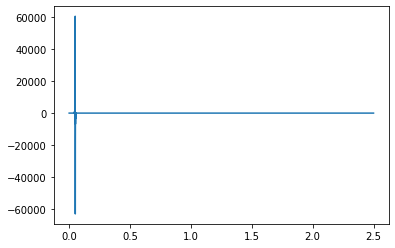

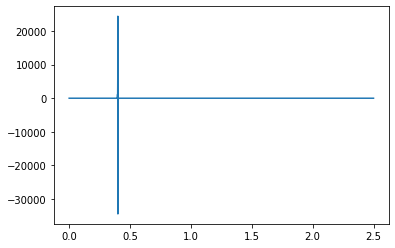

In [41]:
# Plot the estimated sources in the DCT domain. What kind of sparsity to they exhibit? Why?
plt.figure(),plt.plot(np.linspace(0,2.5,t),(S_estf[0]))
plt.figure(),plt.plot(np.linspace(0,2.5,t),(S_estf[1]))


<blockquote>We should choose $\lambda$ greater than zero. Because with a lambda equal or less than zero, we won’t get sparce results. Increasing $\lambda$ increases the regularization, that is, we will loose more and more signals, that progressively have values more distant than zero. <br><br> We can observe that graphically, the results obtained are verry similar to our original S above.  </blockquote>

**2-6)** Transform the sources back in the direct domain. What do you see? Conclude.

(-25.0, 25.0)

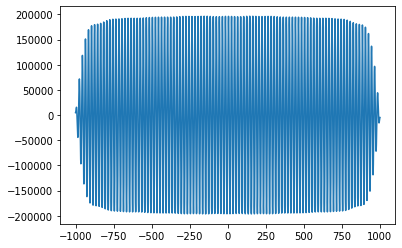

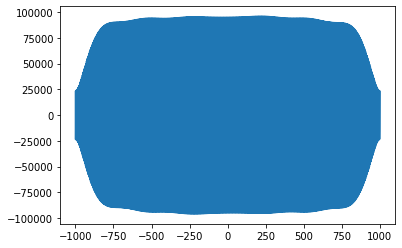

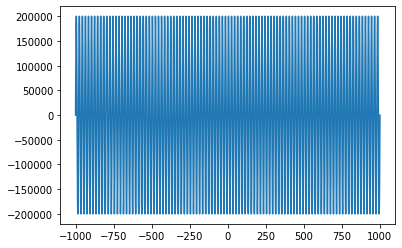

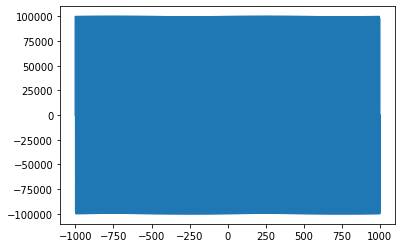

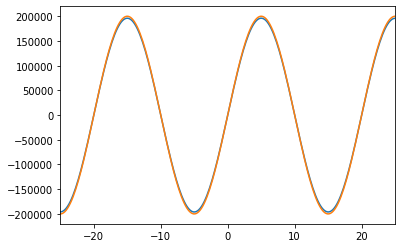

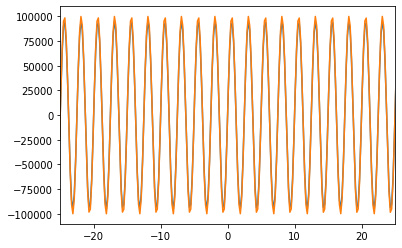

In [37]:
# TO DO : transform the estimated sources in the direct domain? Plot them. Explain the differences with the original sources you observe.

Sf = sff.idct(S_estf)

plt.figure(),plt.plot(x_abs, Sf[0])
plt.figure(),plt.plot(x_abs, Sf[1])
plt.figure(),plt.plot(x_abs, S[0]*20000)
plt.figure(),plt.plot(x_abs, S[1]*20000)

plt.figure()
plt.plot(x_abs, Sf[0])
plt.plot(x_abs, S[0]*20000)
plt.xlim([-25,25])

plt.figure()
plt.plot(x_abs, Sf[1])
plt.plot(x_abs, S[1]*20000)
plt.xlim([-25,25])


# TO DO : compare the central parts of the original and estimated sources.
# CORRECTION : denoising : even with relatively high noise levels, the sources are quite well denoised.

<blockquote>We can observe above that we were able to obtain the original sinus signals from our ISTA estimation of S. To make Sf equal to S, we need to multiply S amplitude by 20000 and also, it can be seen in the graph that for large values in magnitude, the estimated S decreases in amplitude. </blockquote>

**III - Blind Source Separation : PALM**

Let's now delve into the core problem : *blind* source separation, in which **A** is unknown. To leverage sparsity, we will use the PALM algorithm.

Thoughout this whole section, we will re-use the same synthetic data as above (i.e., the one generated in II-1).

1) Write the cost function we want to minimize to perform *blind* sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?




<blockquote>Cost function:
$$argmin_{A \in \mathbb{R}^{m \times n},S \in \mathbb{R}^{n \times t}}\frac{1}{2}||X-AS||^2_F +\lambda||S||_1+\iota_{\{\forall i \in [1,n];||a_{:,j}||^2_{l_2}\le1\}}(A)$$

Where:

*  $\frac{1}{2}||X-AS||^2_F$ is the Data-fidelity.

*  $\lambda||S||_1$ is the Sparsity.

*  $\iota_{\{\forall i \in [1,n];||a_{:,j}||^2_{l_2}\le1\}}(A)$ is the oblique constraint.

This problem is non-smooth because of the $||.||_1$ term. At this form it is also non-convex.
</blockquote>

2) Recall what the gradient of the data fidelity term over A is.


<blockquote>Gradient along the S variable:

$$\nabla f(S^{(k)}) = A^T(AS-X)$$</blockquote>

3) Compte the proximal operator of the oblique constraint. Implement it.

In [38]:
def prox_oblique(A):
    for j in range(A.shape[1]):
        A[:, j] = A[:, j]/max(1, np.linalg.norm(A[:, j]))    
    return A

4) Implement the PALM algorithm to minimize the cost function you wrote in III-1).

In [64]:
def PALM(X,n=2,lamb=0,nbIt = 100):
    S_est = np.zeros((n,X.shape[1]))
    A_est = np.eye(X.shape[0],n)
    for i in range(nbIt):
      S_est = prox_l1(S_est + (0.9/(np.linalg.norm(A_est.T @ A_est)+1e-16))*(np.dot(A_est.T,(X - np.dot(A_est,S_est)))), lamb)
      A_est = prox_oblique(A_est + (0.9/(np.linalg.norm(S_est @ S_est.T)+1e-16))*np.dot((X - np.dot(A_est,S_est)),S_est.T))
    
    return A_est,S_est

5) Launch the PALM algorithm to retrieve both A and S from X. Plot your results. How good is the separation? The separation quality is usually well evaluated comparing the true and estimated A matrices.

(-25.0, 25.0)

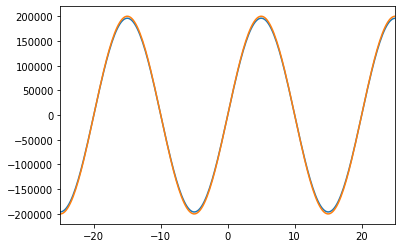

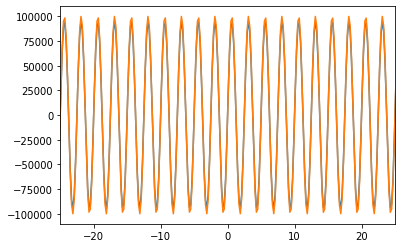

In [65]:
A_fest, S_fest = PALM(Xf, n=2, lamb=1000, nbIt=1000)

S_fest = sff.idct(S_fest)

plt.figure()
plt.plot(x_abs, S_fest[0])
plt.plot(x_abs,200000*np.sin(2*np.pi*0.05*x_abs))
plt.xlim([-25,25])

plt.figure()
plt.plot(x_abs, S_fest[1])
plt.plot(x_abs,100000*np.sin(2*np.pi*0.4*x_abs))
plt.xlim([-25,25])

In [66]:
print('Matrix A:',A)
print('Matrix A_est: ',A_fest)

Matrix A: [[0.5547002  0.24253563]
 [0.83205029 0.9701425 ]]
Matrix A_est:  [[0.55365383 0.24048087]
 [0.83274692 0.97065388]]


<blockquote>As again we can see in the graph, the separation seems good, as the sinus signal obtained in the method PALM is really similar to the one we started with. For the A matrix, as suggested comparing the true and estimated values (printed above), the match up to the 3rd decimal place, which can also be seen as a good match.  </blockquote>